# Task 3: Helper notebook for loading the data and saving the predictions

In [1]:
import pickle
import gzip
import numpy as np
import os
import torch
from torchvision import transforms
from matplotlib import pyplot as plt

In [2]:
from nmf import RNMF

In [3]:
import cv2 as cv

In [258]:
from skimage import exposure

In [4]:
from sklearn.decomposition import NMF

In [5]:
def rnmf(matrix2d, sparsity_coef, max_iter):
    i = 0
    model = NMF(n_components=2, init='random', random_state=0,
                max_iter=800, tol=0.00001)
    W = model.fit_transform(matrix2d)
    H = model.components_

    while i <= max_iter:
        W_old = W
        H_old = H
        # initialize S matrix
        S = matrix2d - np.matmul(W_old, H_old)

        # update S matrix
        S[S > sparsity_coef / 2] = S[S > sparsity_coef / 2] - sparsity_coef / 2
        S[S < sparsity_coef / 2] = 0

        # update W matrix
        W_new = W_old * (np.matmul(np.maximum(matrix2d - S, 0), H_old.T)) / \
                (np.matmul(np.matmul(W_old, H_old), H_old.T))
        nan_ind = np.isnan(W_new)
        inf_ind = np.isinf(W_new)
        W_new[nan_ind] = 0
        W_new[inf_ind] = 1
        W_new = W_new / np.linalg.norm(W_new, ord='fro', keepdims=True)

        # update H matrix
        H_new = H_old * (np.matmul(W_new.T, np.maximum(matrix2d - S, 0))) / \
                (np.matmul(np.matmul(W_new.T, W_new), H_old))
        nan_ind = np.isnan(H_new)
        inf_ind = np.isinf(H_new)
        H_new[nan_ind] = 0
        H_new[inf_ind] = 1

        # normalize W and H
        W = W_new
        # H = H_new
        H = H_new * np.linalg.norm(W_new, ord='fro', keepdims=True)
        i += 1

    return W, H, S

In [6]:
def denoise(h, matrix):
    denoised = np.empty_like(matrix)

    for i in range(matrix.shape[2]):
        denoised[:, :, i] = cv2.fastNlMeansDenoising(
            np.array(matrix[:, :, i] * 255, dtype=np.uint8), h=h,
            templateWindowSize=5, searchWindowSize=11)
    denoised = denoised / 255
    return denoised

In [413]:
idx = 20
nf = train_data[idx]['video'].shape[2]
x = train_data[idx]['video'].shape[0]
y = train_data[idx]['video'].shape[1]
t = np.zeros((x*nf, y))
video = train_data[idx]['video']/255
#video = exposure.equalize_hist(train_data[idx]['video'])
#video = (video - np.mean(video))/np.std(video)
#video = (video - np.min(video))/(np.max(video) - np.min(video))
for i in range(x*nf):
    for j in range(y):
        t[i][j] = video[i%x][j][i//x]

In [414]:
max_iter = 100
sparsity_coef = 0.2
W, H, S = rnmf(t, sparsity_coef, max_iter)

In [415]:
#data = t
#nmf_mdl = RNMF(data, num_bases=2)
#nmf_mdl.initialization()
#nmf_mdl.W = W
#nmf_mdl.factorize(niter=100, show_progress=True)

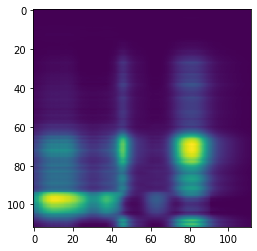

In [416]:
plt.imshow(np.matmul(W, H)[112*2:112*3, :])

In [468]:
f = 2

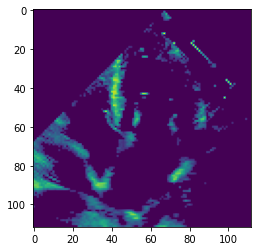

In [482]:
f += 2
plt.imshow(S[x*(f-1):x*f,:])

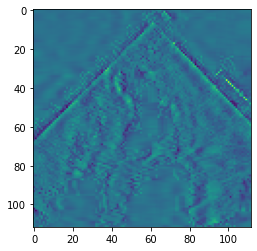

In [339]:
plt.imshow(S[x*(train_data[idx]['frames'][0]-1):x*train_data[idx]['frames'][0],:])

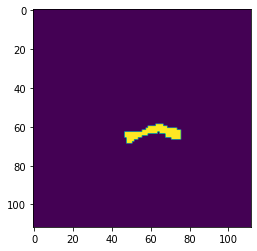

In [483]:
plt.imshow(train_data[idx]['label'][:,:,train_data[idx]['frames'][0]])

In [485]:
pip install medpy

     |████████████████████████████████| 151 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 48.4 MB 1.5 MB/s eta 0:00:01     |███████████▎                    | 17.0 MB 791 kB/s eta 0:00:40
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214957 sha256=aac58ac495dcb3f56791e81164e70a48146e947a5b4223759554b5ba2e9bf724
  Stored in directory: /home/mawskay/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy
Note: you may need to restart the kernel to use updated packages.


/home/mawskay/anaconda3/lib/python3.7/site-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/mawskay/anaconda3/lib/python3.7/site-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


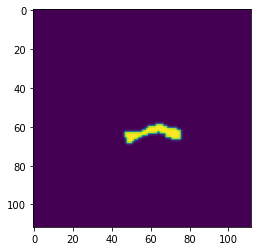

In [486]:
import medpy.filter.smoothing as mp
valve_diffused = mp.anisotropic_diffusion(train_data[idx]['label'][:,:,train_data[idx]['frames'][0]], niter=2, kappa=20, option=3)
plt.imshow(valve_diffused)
#valve_diffused = cv2.erode(valve_diffused, kernel_erode, iterations=1)
#valve_diffused = cv2.dilate(valve_diffused, kernel_dilated, iterations=1)

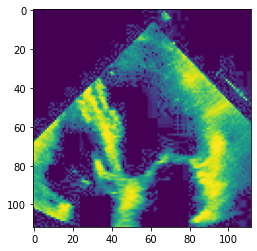

In [378]:
f+=1
plt.imshow(t[112*f:112*(f+1), :])

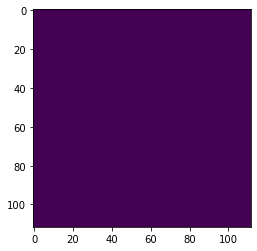

In [47]:
# Calculates dense optical flow by Farneback method
frame = 6
prev_gray = (data[112*frame:112*(frame + 1), :]).astype(np.uint8)
#prev_gray = cv.adaptiveThreshold(prev_gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 3, 0)

gray = (data[112*(frame + 1):112*(frame + 2), :]).astype(np.uint8)
#gray = cv.adaptiveThreshold(prev_gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 3, 0)

flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                   None,
                                   0.7, 3, 15, 3, 5, 1.2, 0)

# Computes the magnitude and angle of the 2D vectors
magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
plt.imshow(magnitude)

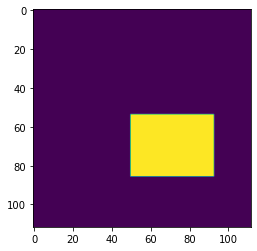

In [72]:
plt.imshow(train_data[idx]['box'])

### Helper functions

In [7]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [8]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [9]:
def evaluate(predictions, targets):
    ious = []
    for p, t in zip(predictions, targets):
        assert p['name'] == t['name']
        prediction = np.array(p['prediction'], dtype=bool)
        target = np.array(t['label'], dtype=bool)

        assert target.shape == prediction.shape
        overlap = prediction*target
        union = prediction + target

        ious.append(overlap.sum()/float(union.sum()))
    
    print("Median IOU: ", np.median(ious))

### Load data, make predictions and save prediction in correct format

In [10]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

In [21]:
t = samples[0]['prediction'].astype(int)
t[500][600][0] = 10
t[500][600][2] = 20

In [9]:
train_data[60]['frames']

[24, 57, 72]

In [10]:
train_data[0]['video'].shape[2]

196

In [11]:
np.where(train_data[60]['box'])

(array([226, 226, 226, ..., 354, 354, 354]),
 array([289, 290, 291, ..., 517, 518, 519]))

In [14]:

idx= 40
t1 = torch.Tensor(train_data[idx]['box'])
t1 = transforms.ToTensor()(transforms.ToPILImage()(t1))

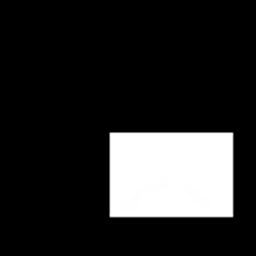

In [15]:
t = torch.Tensor(train_data[idx]['label'][:, :, train_data[idx]['frames'][0]])
transforms.ToPILImage()(t+t1).resize((256,256))

In [20]:
from PIL import Image
def crop_resize(image_obj, coords, x_size = 256, y_size = 256):
    width = image_obj.size[0]
    height = image_obj.size[1]
    coords = (coords[0]*width, coords[1]*height, coords[2]*width, coords[3]*height)
    cropped_image = image_obj.crop(coords)
    resized_image = cropped_image.resize((x_size, y_size), Image.ANTIALIAS)
    return(resized_image.convert('RGB'))

In [23]:
[min(np.where(box)[1]), min(np.where(box)[0]), max(np.where(box)[1]), max(np.where(box)[0])]

[48, 58, 101, 94]

In [26]:
box.size

(112, 112)

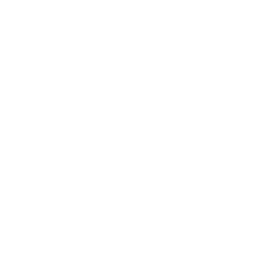

In [37]:
box = transforms.ToPILImage()(torch.Tensor(train_data[idx]['box']))
crop_resize(box, [min(np.where(box)[1])/box.size[0], min(np.where(box)[0])/box.size[0], max(np.where(box)[1])/box.size[0], max(np.where(box)[0])/box.size[0]])

In [111]:
import PIL
image = transforms.ToPILImage()(t+t1).resize((256,256))
converter = PIL.ImageEnhance.Brightness(image)

In [115]:
image.size

(256, 256)

In [112]:
image = converter.enhance((1.4-0.6)*0.5+0.6)+(torch.rand(image.size())-0.5)*1e-3

TypeError: 'tuple' object is not callable

In [100]:
torch.std(t)

tensor(0.1170)

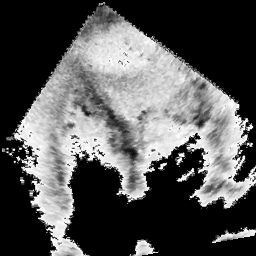

In [44]:
t = torch.Tensor(train_data[60]['video'][:, :, 24])
transforms.ToPILImage()(t).resize((256,256)).rotate(10)

In [31]:
from matplotlib import pyplot as plt
plt.grid(train_data[0]['box'])
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 432x288 with 1 Axes>

In [ ]:
# make prediction for test
predictions = []
for d in test_data:
    prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
    height = prediction.shape[0]
    width = prediction.shape[1]
    prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True
    
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

In [ ]:
# save in correct format
save_zipped_pickle(predictions, 'my_predictions.pkl')